In [74]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load Data

In [75]:
df = pd.read_excel('data.xlsx')

In [76]:
df.rename(columns=df.iloc[0], inplace=True)

In [77]:
df = df.drop(df.index[0])
df = df.dropna(subset=['label'])
df = df.dropna(axis=1)
df = df.drop(columns=['번호','날짜','시간','시편상태','요약','수막두께'])
df = df.apply(pd.to_numeric)

In [78]:
df.head()

,외부 대기온도,최대 대기온도,최소 대기온도,외부 상대습도,이슬점 온도,풍속,풍정,최대풍속,체감온도,열지수,...,In Heat,In EMC,In Air Density,ET,노면 온도1,Wind Samp,Wind Tx,ISS Recept,Arc. Int.,label
1945,-6.4,-6.3,-6.4,56,-13.7,0.4,0.03,0.9,-6.4,-6.7,...,-5.2,-5.2,1.2835,0.0,-8.9,23,1,100.0,1,1
1946,-6.4,-6.3,-6.4,57,-13.5,0.4,0.03,0.9,-6.4,-6.7,...,-5.2,-5.2,1.2833,0.0,-8.9,22,1,95.7,1,1
1947,-6.4,-6.4,-6.4,59,-13.1,0.4,0.03,1.3,-6.4,-6.7,...,-5.2,-5.2,1.2831,0.0,-8.9,24,1,100.0,1,1
1948,-6.4,-6.4,-6.4,62,-12.5,0.4,0.03,0.9,-6.4,-6.6,...,-5.2,-5.2,1.2831,0.0,-8.9,20,1,87.0,1,1
1949,-6.4,-6.4,-6.4,64,-12.1,0.4,0.03,0.9,-6.4,-6.7,...,-5.2,-5.2,1.2829,0.0,-8.9,23,1,100.0,1,1


# Train / Test Split

In [79]:
X = df.drop('label',axis=1).values
y = df['label'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,stratify=y)

In [80]:
X_train.shape

(29255, 35)

In [81]:
X_train = X_train.astype(float)
y_train = y_train.astype(float)

X_test = X_test.astype(float)
y_test = y_test.astype(float)

In [82]:
y_train = np.array(y_train)
y_test = np.array(y_test) 

In [83]:
X_train = np.array(X_train, dtype='float64')
X_test = np.array(X_test, dtype='float64')

In [84]:
X_train

array([[-19.4, -19.4, -19.5, ...,   1. ,  95.7,   1. ],
       [ -7.1,  -7.1,  -7.1, ...,   1. ,  91.3,   1. ],
       [-17.9, -17.9, -18. , ...,   1. , 100. ,   1. ],
       ...,
       [ -9.4,  -9.4,  -9.4, ...,   2. , 100. ,   1. ],
       [ -9.4,  -9.4,  -9.5, ...,   1. , 100. ,   5. ],
       [-18.9, -18.9, -18.9, ...,   1. ,  91.3,   1. ]])

In [85]:
y_train

array([1., 1., 1., ..., 1., 0., 1.])

# Scaling / Normalizing Data

In [86]:
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()

# only fit scaler to the training set

#scaler.fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

In [87]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

# only fit scaler to the training set

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for LSTM

In [55]:
835 * 35

29225

In [56]:
X_train = np.delete(X_train,np.s_[:30], axis=0)
y_train = np.delete(y_train,np.s_[:30], axis=0)

In [57]:
print("X_train shape :",X_train.shape) # Features = 35
print("y_train shape :",y_train.shape)

print("X_test shape :",X_test.shape)
print("y_test shape :",y_test.shape)

X_train shape : (29225, 35)
y_train shape : (29225,)
X_test shape : (9752, 35)
y_test shape : (9752,)


In [59]:
time_steps = 1

X_train = X_train.reshape((-1, time_steps, X_train.shape[1]))
X_test = X_test.reshape((-1, time_steps, X_test.shape[1]))
# shape(data_size, time_steps, features)

In [60]:
X_train.shape

(29225, 1, 35)

In [61]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [62]:
y_train.shape

(29225, 1)

In [63]:
y_test.shape

(9752, 1)

# Building Model

In [64]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=10, mode='min')


In [65]:
from tensorflow.keras.layers import Dense, Activation, Dropout, Bidirectional, GlobalMaxPool1D

model = keras.models.Sequential()

model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=32, return_sequences=True, input_shape=(1, 35)))) # Timesteps = 1, Features = 35

model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=16, return_sequences=True)))

model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=8, return_sequences=True)))

model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=4)))

model.add(Dense(4, activation='tanh'))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [66]:
epochs = 50
batch_size = 256

history=model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/50


2022-08-04 15:06:21.191402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-04 15:06:21.973974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-04 15:06:21.992022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-04 15:06:22.073686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-04 15:06:22.086267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-04 15:06:22.172633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-04 15:06:22.185422: I tensorflow/core/grappler/optimizers/cust

92/92 - 15s - loss: 0.5272 - accuracy: 0.8061 - val_loss: 0.3170 - val_accuracy: 0.9061 - 15s/epoch - 166ms/step
Epoch 2/50
92/92 - 3s - loss: 0.2558 - accuracy: 0.9092 - val_loss: 0.2128 - val_accuracy: 0.9196 - 3s/epoch - 33ms/step
Epoch 3/50
92/92 - 3s - loss: 0.1911 - accuracy: 0.9241 - val_loss: 0.1661 - val_accuracy: 0.9386 - 3s/epoch - 33ms/step
Epoch 4/50
92/92 - 3s - loss: 0.1612 - accuracy: 0.9361 - val_loss: 0.1479 - val_accuracy: 0.9458 - 3s/epoch - 33ms/step
Epoch 5/50
92/92 - 3s - loss: 0.1436 - accuracy: 0.9469 - val_loss: 0.1341 - val_accuracy: 0.9533 - 3s/epoch - 36ms/step
Epoch 6/50
92/92 - 3s - loss: 0.1308 - accuracy: 0.9527 - val_loss: 0.1253 - val_accuracy: 0.9545 - 3s/epoch - 35ms/step
Epoch 7/50
92/92 - 3s - loss: 0.1216 - accuracy: 0.9559 - val_loss: 0.1217 - val_accuracy: 0.9567 - 3s/epoch - 36ms/step
Epoch 8/50
92/92 - 3s - loss: 0.1118 - accuracy: 0.9605 - val_loss: 0.1137 - val_accuracy: 0.9572 - 3s/epoch - 34ms/step
Epoch 9/50
92/92 - 3s - loss: 0.1032 - a

In [67]:
model.summary()
print(X_train.shape, y_train.shape)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 1, 64)            17408     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 1, 32)            10368     
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, 1, 16)            2624      
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 8)                672       
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 4)                

# Evaluate Model

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

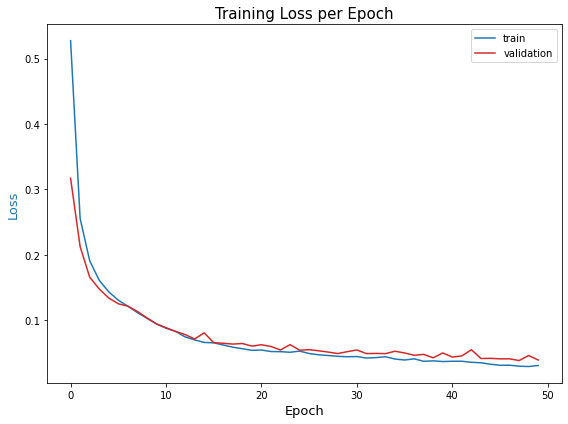

In [69]:
model.history.history
loss = model.history.history['loss']

val_loss = model.history.history['val_loss']

fig, ax1 = plt.subplots(figsize=(8,6))

color_1 = 'tab:blue'
color_2 = 'tab:red'

ax1.set_title("Training Loss per Epoch", fontsize=15)
ax1.set_xlabel('Epoch', fontsize = 13)
ax1.set_ylabel('Loss',fontsize = 13, color=color_1)

ax1.plot(range(len(loss)),loss, color=color_1, label = 'train')
ax1.plot(range(len(val_loss)),val_loss, color=color_2, label = 'validation')
ax1.tick_params(axis='y')
ax1.legend()

fig.tight_layout()
plt.show()

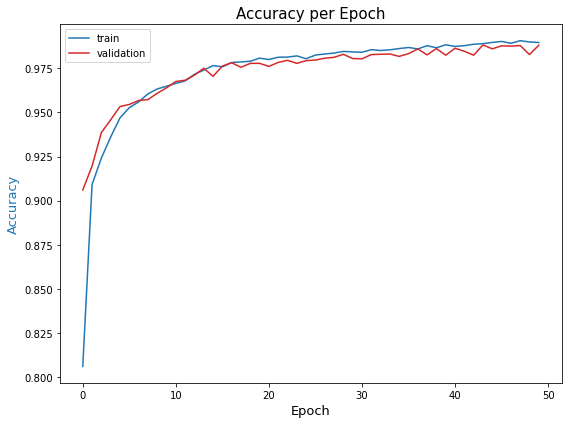

In [70]:
accuracy = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']

fig, ax1 = plt.subplots(figsize=(8,6))

color_1 = 'tab:blue'
color_2 = 'tab:red'

ax1.set_title("Accuracy per Epoch", fontsize=15)
ax1.set_xlabel('Epoch', fontsize = 13)
ax1.set_ylabel('Accuracy',fontsize = 13, color=color_1)

ax1.plot(range(len(accuracy)),accuracy, color=color_1, label = 'train')
ax1.plot(range(len(val_accuracy)),val_accuracy, color=color_2, label = 'validation')
ax1.tick_params(axis='y')
ax1.legend()

fig.tight_layout()
plt.show()

In [71]:
from sklearn.metrics import classification_report,confusion_matrix

predictions = (model.predict(X_test) > 0.5).astype("int32")

print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

2022-08-04 15:09:08.529674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-04 15:09:08.808580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-04 15:09:08.815838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-04 15:09:08.880824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-04 15:09:08.888258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-04 15:09:08.960451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-04 15:09:08.967701: I tensorflow/core/grappler/optimizers/cust

  4/305 [..............................] - ETA: 6s   

2022-08-04 15:09:09.021713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-04 15:09:09.029543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


305/305 [==============================] - 7s 12ms/step
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      3900
         1.0       0.99      0.99      0.99      5852

    accuracy                           0.99      9752
   macro avg       0.99      0.99      0.99      9752
weighted avg       0.99      0.99      0.99      9752

[[3845   55]
 [  57 5795]]


In [72]:
model.save("Whiskey_LSTM.h5")